# Process the gravity data



In [1]:
%matplotlib inline
from __future__ import division, print_function
import datetime
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from fatiando.gravmag import normal_gravity, tesseroid
from fatiando.mesher import Tesseroid
from fatiando import gridder
from load_icgem import load_icgem_gdf

In [2]:
datapath = 'data/{}'
gravfile = 'go_cons_gcf_2_tim_r5-africa-1deg.gdf'
topofile = 'etopo1-africa-1deg.gdf'
topoexfile = 'etopo1-africa-1deg-expanded.gdf'
outfile = 'processed-tim_r5-africa-1deg.txt'

## The raw gravity data

In [3]:
data = load_icgem_gdf(datapath.format(gravfile))

In [4]:
data.keys()

['area',
 'longitude',
 'height',
 'shape',
 'gridstep',
 'latitude',
 'gravity_ell',
 'metadata']

In [5]:
print(data['metadata'])

generating_institute     gfz-potsdam
     generating_date     2016/07/12
        product_type     gravity_field
                body     earth
           modelname     go_cons_gcf_2_tim_r5
     max_used_degree           280
         tide_system     tide_free
          functional     gravity_ell  (centrifugal term included)
                unit     mgal
          refsysname     WGS84
            gmrefpot      3.98600441800E+14 m**3/s**2
        radiusrefpot     6378137.000 m
          flatrefpot      3.352810664747480E-03   (1/298.25722356300)
         omegarefpot      7.29211500000E-05 1/s
       long_lat_unit     degree
      latlimit_north       40.000000000000    
      latlimit_south      -40.000000000000    
      longlimit_west      -20.000000000000    
      longlimit_east       55.000000000000    
            gridstep       1.0000000000000    
     height_over_ell       4000.0000 m
  latitude_parallels            81
 longitude_parallels            76
number_of_gridpoints       

In [6]:
lat = data['latitude']
lon = data['longitude']
height = data['height']
grav = data['gravity_ell']
shape = data['shape']
area = data['area']

In [7]:
print(area)

[-40.0, 40.0, -20.0, 55.0]


To choose colormaps:

* http://matplotlib.org/examples/color/colormaps_reference.html
* http://matplotlib.org/users/colormaps.html

In [8]:
s, n, w, e = area
bm = Basemap(projection='merc', llcrnrlat=s, llcrnrlon=w, urcrnrlat=n, urcrnrlon=e, lat_ts=(n + s)/2)

In [9]:
y, x = bm(lon.reshape(shape), lat.reshape(shape))

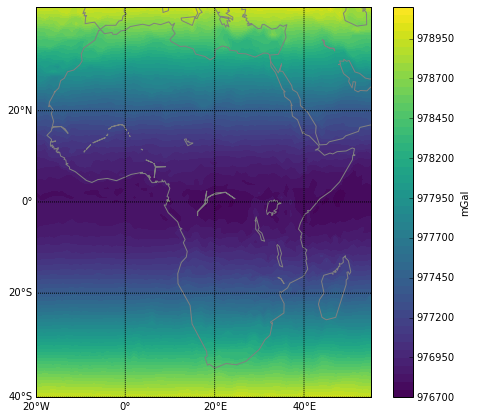

In [10]:
plt.figure(figsize=(8, 7))
bm.contourf(y, x, grav.reshape(shape), 50, cmap='viridis')
cb = plt.colorbar()
cb.set_label('mGal')
bm.drawmeridians(np.arange(w, e, 20), labels=[0, 0, 0, 1])
bm.drawparallels(np.arange(s, n, 20), labels=[1, 0, 0, 0])
bm.drawcoastlines(color='grey')

## Calculate the disturbance

In [11]:
gammap = normal_gravity.gamma_closed_form(lat, height)

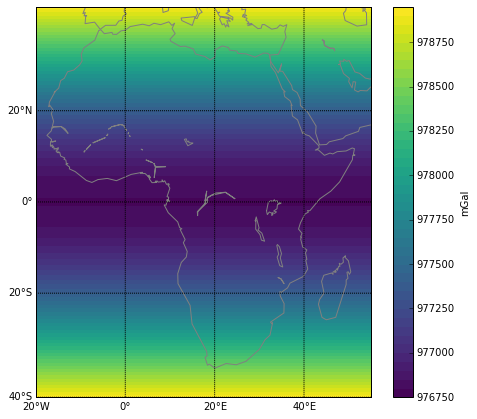

In [12]:
plt.figure(figsize=(8, 7))
bm.contourf(y, x, gammap.reshape(shape), 50, cmap='viridis')
cb = plt.colorbar()
cb.set_label('mGal')
bm.drawmeridians(np.arange(w, e, 20), labels=[0, 0, 0, 1])
bm.drawparallels(np.arange(s, n, 20), labels=[1, 0, 0, 0])
bm.drawcoastlines(color='grey')

The disturbance is the difference between the observed gravity and the normal gravity at the same point:

$$
\delta(P) = g(P) - \gamma(P)
$$

In [13]:
disturbance = grav - gammap

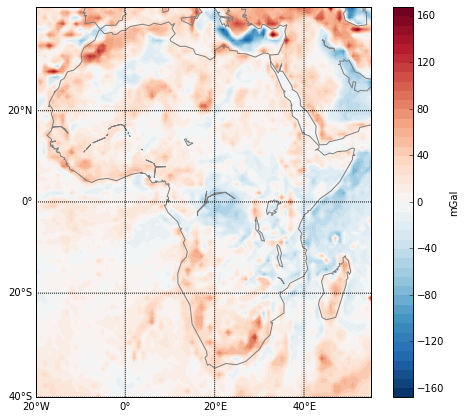

In [14]:
plt.figure(figsize=(8, 7))
bm.contourf(y, x, disturbance.reshape(shape), 50, cmap='RdBu_r')
cb = plt.colorbar()
cb.set_label('mGal')
bm.drawmeridians(np.arange(w, e, 20), labels=[0, 0, 0, 1])
bm.drawparallels(np.arange(s, n, 20), labels=[1, 0, 0, 0])
bm.drawcoastlines(color='grey')

## Calculate the simple Bouguer anomaly

In [15]:
etopo = load_icgem_gdf(datapath.format(topofile))

In [16]:
etopo.keys()

['area',
 'longitude',
 'shape',
 'topography_grd',
 'gridstep',
 'latitude',
 'metadata']

In [17]:
topo = etopo['topography_grd']

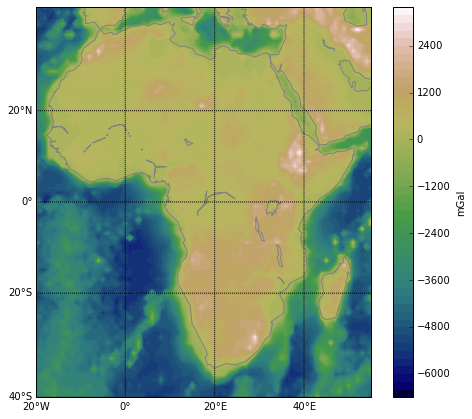

In [18]:
plt.figure(figsize=(8, 7))
bm.contourf(y, x, topo.reshape(shape), 50, cmap='gist_earth')
cb = plt.colorbar()
cb.set_label('mGal')
bm.drawmeridians(np.arange(w, e, 20), labels=[0, 0, 0, 1])
bm.drawparallels(np.arange(s, n, 20), labels=[1, 0, 0, 0])
bm.drawcoastlines(color='grey')

In [19]:
bouguer = disturbance - normal_gravity.bouguer_plate(topo)

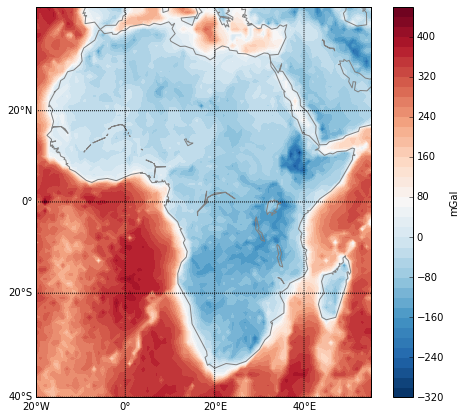

In [20]:
plt.figure(figsize=(8, 7))
bm.contourf(y, x, bouguer.reshape(shape), 50, cmap='RdBu_r')
cb = plt.colorbar()
cb.set_label('mGal')
bm.drawmeridians(np.arange(w, e, 20), labels=[0, 0, 0, 1])
bm.drawparallels(np.arange(s, n, 20), labels=[1, 0, 0, 0])
bm.drawcoastlines(color='grey')

## Complete Bouguer

In [21]:
etopoex = load_icgem_gdf(datapath.format(topoexfile))

In [22]:
step = etopoex['gridstep']
print('Grid spacing:', step)
latex = etopoex['latitude']
lonex = etopoex['longitude']
topoex = etopoex['topography_grd']

Grid spacing: 1.0


In [23]:
def modelgen(lat, lon, topo, step):
    for i in range(topo.size):
        if topo[i] >= 0:
            t = Tesseroid(w=lon[i] - step/2,
                          e=lon[i] + step/2,
                          s=lat[i] - step/2,
                          n=lat[i] + step/2,
                          top=topo[i],
                          bottom=0,
                          props={'density': 2670})
        else:
            t = Tesseroid(w=lon[i] - step/2,
                          e=lon[i] + step/2,
                          s=lat[i] - step/2,
                          n=lat[i] + step/2,
                          top=0,
                          bottom=topo[i],
                          props={'density': 1040 - 2670})        
        yield t

In [24]:
%%time
modelo = modelgen(latex, lonex, topoex, step)
topo_effect = tesseroid.gz(lon, lat, height, modelo)

/home/leo/bin/anaconda/envs/braitenberg2015/lib/python2.7/site-packages/fatiando/gravmag/tesseroid.py:282: RuntimeWarning: Encountered tesseroid with dimensions smaller than the numerical threshold (1e-6 degrees or 1e-3 m). Ignoring this tesseroid.
  warnings.warn(msg, RuntimeWarning)
/home/leo/bin/anaconda/envs/braitenberg2015/lib/python2.7/site-packages/fatiando/gravmag/tesseroid.py:351: RuntimeWarning: Stopped dividing a tesseroid because it's dimensions would be below the minimum numerical threshold (1e-6 degrees or 1e-3 m). Will compute without division. Cannot guarantee the accuracy of the solution.
  warnings.warn(warning_msg, RuntimeWarning)


CPU times: user 48.8 s, sys: 48 ms, total: 48.8 s
Wall time: 48.7 s


In [25]:
bouguer_full = disturbance - topo_effect

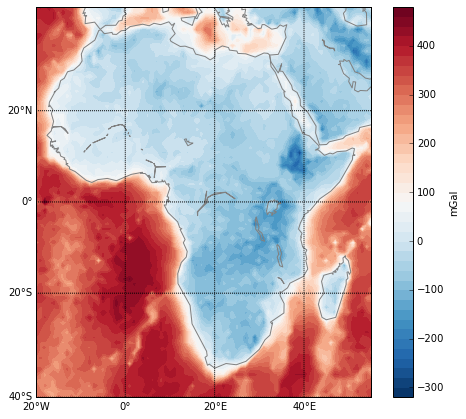

In [26]:
plt.figure(figsize=(8, 7))
bm.contourf(y, x, bouguer_full.reshape(shape), 50, cmap='RdBu_r')
cb = plt.colorbar()
cb.set_label('mGal')
bm.drawmeridians(np.arange(w, e, 20), labels=[0, 0, 0, 1])
bm.drawparallels(np.arange(s, n, 20), labels=[1, 0, 0, 0])
bm.drawcoastlines(color='grey')

## Save the results to a text file

In [66]:
date = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
header = """# Generated by data_processing.ipynb
# Date: {date}
# Raw gravity data: {datafile}
# Topography: {topofile}
# Topography (extended): {topoexfile}
# Projection: {proj}
# Grid shape: {shape}
# Columns: lat  lon  x  y  height  gravity  disturbance  topo  bouguer_simple  topo_effect  bouguer_full
""".format(date=date, 
           datafile=gravfile,
           topofile=topofile,
           topoexfile=topoexfile,
           proj=bm.projection,
           shape=shape)
print(header)

# Generated by data_processing.ipynb
# Date: 14 July 2016 17:59:50 UTC
# Raw gravity data: go_cons_gcf_2_tim_r5-africa-1deg.gdf
# Topography: etopo1-africa-1deg.gdf
# Topography (extended): etopo1-africa-1deg-expanded.gdf
# Projection: merc
# Grid shape: (81, 76)
# Columns: lat  lon  x  y  height  gravity  disturbance  topo  bouguer_simple  topo_effect  bouguer_full



In [67]:
with open(datapath.format(outfile), 'w') as f:
    f.write(header)
    datamatrix = np.array([lat, lon, x.ravel(), y.ravel(), height, grav, disturbance, 
                           topo, bouguer, topo_effect, bouguer_full]).T
    np.savetxt(f, datamatrix, fmt='%.4f')